# Imports

In [1]:
from functions import *

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
plt.style.use('fivethirtyeight')
#sns.set()
#pd.options.display.max_columns = 100

# Read Master data

In [2]:
master_df = pd.read_csv('master_final_cleaned.csv')
master_df.head()
master_df.shape

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,client_credit_SK_DPD_DEF_min_count,client_credit_SK_DPD_DEF_min_mean,client_credit_SK_DPD_DEF_min_max,client_credit_SK_DPD_DEF_min_min,client_credit_SK_DPD_DEF_min_sum,client_credit_SK_DPD_DEF_sum_count,client_credit_SK_DPD_DEF_sum_mean,client_credit_SK_DPD_DEF_sum_max,client_credit_SK_DPD_DEF_sum_min,client_credit_SK_DPD_DEF_sum_sum
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,9461,-637,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,16765,-1188,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,19046,-225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,19005,-3039,...,6.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,19932,-3038,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(307511, 1609)

### select a part of the entire data to detect important features due to memory issues

#### first shuffle the data and take a sample randomly

In [3]:
master_df = shuffle(master_df)
master_df_cut = master_df.sample(10_000).copy() 

In [4]:
# free memory
gc.enable()
del master_df
gc.collect()

0

# instantiate xgboost model

In [5]:
#instantiate XGB Regressor
xgbr = xgb.XGBRegressor(n_jobs=-1,objective='binary:logistic', eval_metric='auc')

#Hyper Parameter Optimization
params = {
   "learning_rate": [0.01, 0.05, 0.10],
    "max_depth": [4, 8, 12],
    "min_child_weight": [1,3,7],
    "gamma": [0.0,0.2,0.4],
    "colsample_bytree": [0.3,0.7],
    "n_estimators" : [100,300]
}

random_search = RandomizedSearchCV(xgbr,
                                   param_distributions=params,
                                   scoring='roc_auc',
                                   n_jobs=-1,cv=3,verbose=3)

# Build Xgboost Model

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  30 | elapsed:  8.8min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  9.4min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          eval_metric='auc', gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_c...
                                          validate_parameters=False,
                                          verbosity=None),
                   iid='deprecated', n_iter=10, n_jobs=-1,
   

train score: 0.36944084054904947
test score: 0.028871854125793184


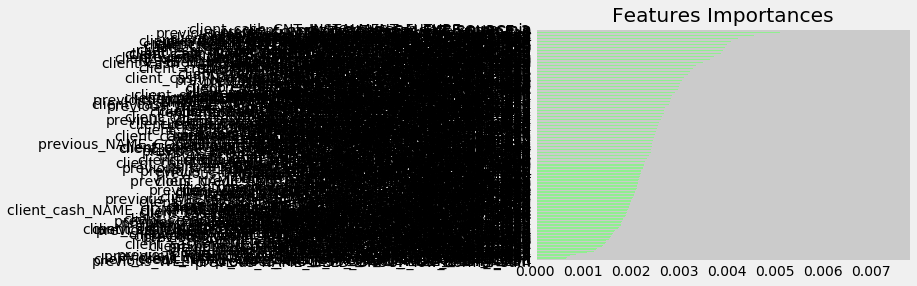

In [6]:
# Prepare data to run rhe model
X = master_df_cut.drop(['TARGET','SK_ID_CURR'],axis=1).copy()
y = master_df_cut['TARGET'].copy()


#split data into train,test (80,20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,random_state=7)

# Standardization
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

random_search.fit(X_train_scaled,y_train)
y_pred_test = random_search.predict(X_test_scaled)
y_pred_train = random_search.predict(X_train_scaled)

best_model = random_search.best_estimator_


print("train score:", r2_score(y_train,y_pred_train))
print("test score:", r2_score(y_test,y_pred_test))
important_features = print_importance_features(best_model, X_train.columns)

In [7]:
random_search.best_estimator_

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, eval_metric='auc',
             gamma=0.2, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=7, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=-1,
             num_parallel_tree=1, objective='binary:logistic', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)